In [4]:
import numpy as np 
import cv2
from skimage import filters
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu



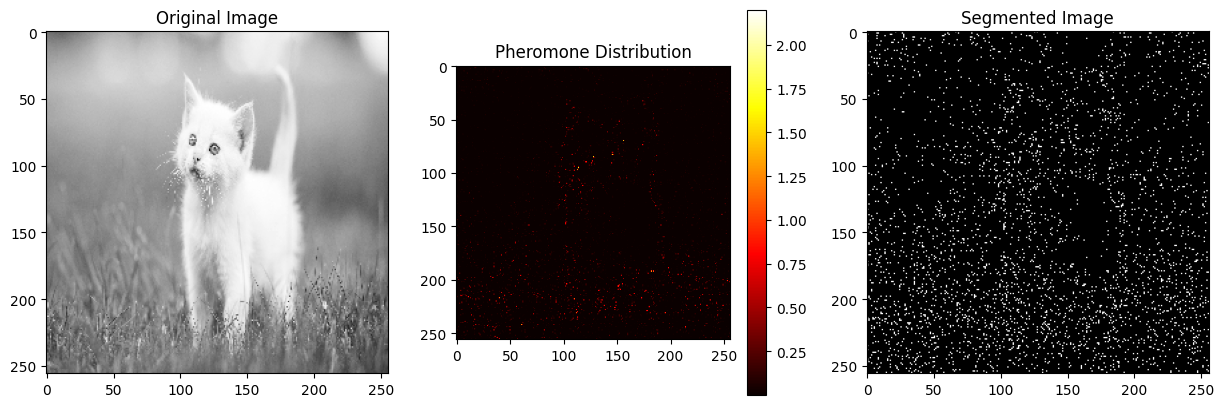

In [5]:
def pheromone_matrix(image,initial_pheromone=0.1):
    return np.full(image.shape,initial_pheromone)

def compute_transition_probabilities(pheromones,heuristic,alpha=1,beta=1):
    numerator = (pheromones ** alpha) * (heuristic ** beta)
    denominator = np.sum(numerator)
    return numerator / denominator


def evaporate_pheromones(pheromones, evaporation_rate=0.1):
    """Evaporate pheromone levels."""
    return (1 - evaporation_rate) * pheromones


def update_pheromones(pheromones, path, contribution=1):
    """Update pheromone levels based on ant paths."""
    for i, j in path:
        pheromones[i, j] += contribution
    return pheromones

image="test_images\cat1.jpg"
image = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image,(256,256))


#Normalize the image 
image = image / 255.0

#initialize pheromones
pheromones=pheromone_matrix(image)

# Compute heuristic based on edges
heuristic = sobel(image)

# ACO Parameters
n_ants = 200
n_iterations = 50
evaporation_rate = 0.1

# ACO Loop
for iteration in range(n_iterations):
    for _ in range(n_ants):
        # Randomly select a pixel
        x, y = np.random.randint(0, image.shape[0]), np.random.randint(0, image.shape[1])
        # Update pheromone using heuristic
        pheromones[x, y] += heuristic[x, y] * 10
    # Evaporate pheromones
    pheromones *= (1 - evaporation_rate)

# Adaptive thresholding
threshold = np.percentile(pheromones, 95)
segmented_image = (pheromones >= threshold).astype(np.uint8) * 255

# Visualize results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Pheromone Distribution")
plt.imshow(pheromones, cmap='hot')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Segmented Image")
plt.imshow(segmented_image, cmap='gray')
plt.show()


# #ACO

# n_ants = 200  # Number of ants
# n_iterations = 50  # Number of iterations

# for iteration in range(n_iterations):
#     path = []  # Store paths of ants
#     rows, cols = image.shape
#     for _ in range(n_ants):
#         x, y = np.random.randint(0, rows), np.random.randint(0, cols)
#         pheromones[x, y] += 5  # Increase pheromone contribution
#         path.append((x, y))

#     pheromones = evaporate_pheromones(pheromones)

# # Dynamic thresholding using Otsu's method
# from skimage.filters import threshold_otsu

# threshold = threshold_otsu(pheromones)
# segmented_image = (pheromones >= threshold).astype(np.uint8) * 255

# # Visualize results
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.title("Original Image")
# plt.imshow(image, cmap='gray')

# plt.subplot(1, 3, 2)
# plt.title("Pheromone Distribution")
# plt.imshow(pheromones, cmap='hot')
# plt.colorbar()

# plt.subplot(1, 3, 3)
# plt.title("Segmented Image")
# plt.imshow(segmented_image, cmap='gray')
# plt.show()



